In [1]:
import torch
from torch import nn
from PIL import Image
import numpy as np

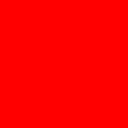

In [2]:
img = Image.new('RGB', (128, 128), color = 'red')
img.show()

In [3]:
img_array = np.array(img)
img_array = img_array/255
img_array = img_array.transpose(2, 0, 1).astype(np.float32)

In [4]:
img_tensor = torch.from_numpy(img_array)
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape)

torch.Size([1, 3, 128, 128])


In [5]:
def image_to_tensor(image: Image) -> torch.Tensor:
    img_array = np.array(image)
    img_array = img_array/255
    img_array = img_array.transpose(2, 0, 1).astype(np.float32)
    img_tensor = torch.from_numpy(img_array)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def tensor_to_image(tensor: torch.Tensor) -> Image:
    img_array = tensor.squeeze(0).numpy()
    img_array = img_array.transpose(1, 2, 0)
    img_array = img_array*255
    img_array = img_array.astype(np.uint8)
    image = Image.fromarray(img_array)
    return image

In [6]:
color = tuple[int, int, int]
def create_empty_image(resolution: int, color: color=(0,0,0)) -> Image:
    return Image.new('RGB', (resolution, resolution), color = color)

In [7]:
init_tensor = image_to_tensor(create_empty_image(128, color=(255, 0, 0)))
target_tensor = image_to_tensor(create_empty_image(128, color=(0, 255, 0)))

step : 0, loss :  138.296616)
step : 1, loss :  136.697449)
step : 2, loss :  133.484924)
step : 3, loss :  128.671936)
step : 4, loss :  122.261955)
step : 5, loss :  114.252052)
step : 6, loss :  104.648865)
step : 7, loss :  93.452911)
step : 8, loss :  80.680923)
step : 9, loss :  66.360771)
step : 10, loss :  50.546074)
step : 11, loss :  33.437279)
step : 12, loss :  16.151430)
step : 13, loss :  12.513351)
step : 14, loss :  28.872328)
step : 15, loss :  46.138206)
step : 16, loss :  62.219967)
step : 17, loss :  76.840500)
step : 18, loss :  89.922966)
step : 19, loss :  101.424759)
step : 20, loss :  111.351677)
step : 21, loss :  119.686073)
step : 22, loss :  126.411407)
step : 23, loss :  131.542572)
step : 24, loss :  135.065720)
step : 25, loss :  136.994492)
step : 26, loss :  137.310104)
step : 27, loss :  136.031906)
step : 28, loss :  133.138245)
step : 29, loss :  128.650726)
step : 30, loss :  122.554878)
step : 31, loss :  114.865601)
step : 32, loss :  105.574638)

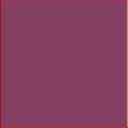

In [10]:
# init_tensor.grad  
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
lr = 1e-5
num_step = 100

for step in range(num_step):
    y = conv(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        print(f'step : {step}, loss : {loss.item(): 3f})')
        for param in conv.parameters():
            assert param.grad is not None
            param -= lr * param.grad
    # conv.zero_grad()

result = conv(init_tensor)
tensor_to_image(result.data)



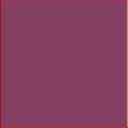

In [12]:
tensor_to_image(conv(init_tensor).detach())

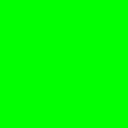

In [13]:
tensor_to_image(target_tensor)

In [14]:
class Linear(nn.Module):
    def __init__(self, in_features: int=1, out_features: int=1) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight.t() + self.bias

linear = Linear(in_features=3, out_features=3)
x = torch.randn(1, 3)
target_tensor = torch.randn(1, 3)
y = linear(x)
loss = ((y - target_tensor)**2).mean()
loss.backward()

In [15]:
linear.weight.grad

tensor([[-0.7509,  0.4282, -0.6134],
        [-2.1181,  1.2078, -1.7301],
        [ 2.4860, -1.4176,  2.0306]])

In [21]:
class Resblock(nn.Module):
    def __init__(self, in_channels : int = 1, out_channels : int = 1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.activation = nn.SiLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.activation(y)
        y = self.conv2(y)
        # y = self.activation(y)
        return y + x


In [22]:
block = Resblock(in_channels = 3, out_channels =3)

lr = 1e-5
num_step = 10000
for step in range(num_step):
    y = block(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        print(f'step : {step}, loss : {loss.item(): 3f})')
        for param in block.parameters():
            assert param.grad is not None
            param -= lr * param.grad
    # conv.zero_grad()
            
result = conv(init_tensor)
tensor_to_image(result.data)


RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 3

In [51]:
class Encoder(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.silu = nn.SiLU()
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.maxpool(y)
        y = self.silu(y)
        y = self.conv2(y)
        y = self.maxpool(y)
        y = self.silu(y)
        y = self.conv3(y)
        y = self.maxpool(y)
        y = self.silu(y)
        y = self.conv4(y)
        y = self.maxpool(y)
        # y = self.silu(y)
        return y

class Decoder(nn.Module):
    def __init__(self, output_channels: int = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, output_channels, 3, padding=1)
        self.silu = nn.SiLU()
        self.upsample = nn.Upsample(scale_factor=2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.upsample(y)
        y = self.silu(y)
        y = self.conv2(y)
        y = self.upsample(y)
        y = self.silu(y)
        y = self.conv3(y)
        y = self.upsample(y)
        y = self.silu(y)
        y = self.conv4(y)
        # y = self.silu(y)
        y = self.upsample(y)
        return y

In [52]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__() # type: ignore
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))


In [40]:
class Dataset:
    def __init__(self) -> None:
        self.data = list(range(100))

    def __len__(self) -> int:
        return len(self.data)

    def __str__(self) -> str:
        return f'Dataset(len={len(self)})'

    def __repr__(self) -> str:
        return str(self)
    
    def __getitem__(self, key : str|int) -> int:
        match key:
            case key if isinstance(key, str):
                raise ValueError('Dataset does not take string as index.')
            case _:
                return self.data[key]


In [67]:
dataset = Dataset()
dataset[2]
# print(dataset)

2

In [42]:
device = torch.device('cuda')

step 0 : loss 127.6457290649414
step 1 : loss 127.33029174804688
step 2 : loss 127.00260162353516
step 3 : loss 126.64268493652344
step 4 : loss 126.22867584228516
step 5 : loss 125.73936462402344
step 6 : loss 125.13591003417969
step 7 : loss 124.37490844726562
step 8 : loss 123.40460205078125
step 9 : loss 122.14845275878906
step 10 : loss 120.51678466796875
step 11 : loss 118.3977279663086
step 12 : loss 115.65338134765625
step 13 : loss 112.12434387207031
step 14 : loss 107.61593627929688
step 15 : loss 101.91558837890625
step 16 : loss 94.80987548828125
step 17 : loss 86.15779876708984
step 18 : loss 76.09049224853516
step 19 : loss 65.58273315429688
step 20 : loss 57.867218017578125
step 21 : loss 57.84002685546875
step 22 : loss 60.51716613769531
step 23 : loss 57.675254821777344
step 24 : loss 50.589595794677734
step 25 : loss 43.270164489746094
step 26 : loss 39.01624298095703
step 27 : loss 38.548274993896484
step 28 : loss 40.0908203125
step 29 : loss 41.796688079833984
step

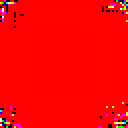

In [53]:
autoencoder = AutoEncoder()
lr = 1e-4
num_steps = 1000
optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    y = autoencoder(init_tensor)
    loss = (y-init_tensor).norm()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

result = autoencoder(init_tensor)
tensor_to_image(result.data)


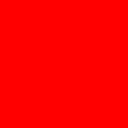

In [49]:
tensor_to_image(init_tensor)

In [125]:
from PIL import Image, ImageDraw
import random

def generate_image(size): # , num_images):
    # for i in range(num_images):
    # Create a new image with a random background color
    img = Image.new("RGB", size, color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

    # Get a drawing context
    draw = ImageDraw.Draw(img)

    # Choose a random shape (circle, square, or triangle)
    # shape = random.choice(["circle", "square", "triangle"])
    shape = "circle"

    # Choose a random position
    position = (random.randint(20, size[0]-20), random.randint(20, size[1]-20))

    # Choose a random color for the shape
    shape_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    # Draw the shape on the image
    if shape == "circle":
        draw.ellipse([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
    elif shape == "square":
        draw.rectangle([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
    elif shape == "triangle":
        draw.polygon([(position[0], position[1]-20), (position[0]-20, position[1]+20), (position[0]+20, position[1]+20)], fill=shape_color)

    # Show the image
    # img.show()
    # print(type(img))
    return img

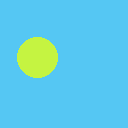

In [126]:
image_size = (128, 128)
num_images = 5  # Change this to the number of images you want to generate

new_image = generate_image(image_size)
new_image.show()

step 0 : loss 161.52218627929688
step 1 : loss 161.2043914794922
step 2 : loss 160.88043212890625
step 3 : loss 160.5339813232422
step 4 : loss 160.14744567871094
step 5 : loss 159.70086669921875
step 6 : loss 159.16635131835938
step 7 : loss 158.51004028320312
step 8 : loss 157.68443298339844
step 9 : loss 156.62936401367188
step 10 : loss 155.26724243164062
step 11 : loss 153.50189208984375
step 12 : loss 151.2122802734375
step 13 : loss 148.25054931640625
step 14 : loss 144.4362030029297
step 15 : loss 139.55438232421875
step 16 : loss 133.35879516601562
step 17 : loss 125.58444213867188
step 18 : loss 115.98430633544922
step 19 : loss 104.42536163330078
step 20 : loss 91.14025115966797
step 21 : loss 77.4955825805664
step 22 : loss 68.03919982910156
step 23 : loss 70.60318756103516
step 24 : loss 78.18612670898438
step 25 : loss 78.10783386230469
step 26 : loss 71.59979248046875
step 27 : loss 63.5612678527832
step 28 : loss 57.93244552612305
step 29 : loss 56.01136779785156
step 3

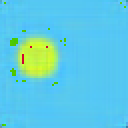

In [127]:
new_init_tensor = image_to_tensor(new_image)

autoencoder = AutoEncoder()
lr = 1e-4
num_steps = 1000
optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    y = autoencoder(new_init_tensor)
    loss = (y-new_init_tensor).norm()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

result = autoencoder(new_init_tensor)
tensor_to_image(result.data)

In [128]:
num_images_train = 20
num_images_test = 5
dataset_train = [None] * num_images_train
dataset_test = [None] * num_images_test

for i in range(num_images_train):
    dataset_train[i] = image_to_tensor(generate_image(image_size))

for i in range(num_images_test):
    dataset_test[i] = image_to_tensor(generate_image(image_size))

# dataset

In [135]:
autoencoder = AutoEncoder()
autoencoder.train()
lr = 1e-4
num_steps = 1000

optimizer = torch.optim.Adam(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    loss_iter = 0
    for image in dataset_train:
        y = autoencoder(image)
        loss = (y-image).norm()
        loss_iter += loss
    loss = loss_iter/num_images_train
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

# result = autoencoder(new_init_tensor)
# tensor_to_image(result.data)

step 0 : loss 116.97880554199219
step 1 : loss 116.64715576171875
step 2 : loss 116.29903411865234
step 3 : loss 115.91722106933594
step 4 : loss 115.4833984375
step 5 : loss 114.97599029541016
step 6 : loss 114.3666000366211
step 7 : loss 113.6183090209961
step 8 : loss 112.6842269897461
step 9 : loss 111.5044174194336
step 10 : loss 110.00482177734375
step 11 : loss 108.0951156616211
step 12 : loss 105.66751861572266
step 13 : loss 102.5966796875
step 14 : loss 98.74269104003906
step 15 : loss 93.96373748779297
step 16 : loss 88.15357971191406
step 17 : loss 81.33827209472656
step 18 : loss 73.92469787597656
step 19 : loss 67.32197570800781
step 20 : loss 64.80978393554688
step 21 : loss 68.824462890625
step 22 : loss 72.8460464477539
step 23 : loss 72.23407745361328
step 24 : loss 68.79522705078125
step 25 : loss 65.153564453125
step 26 : loss 62.92864227294922
step 27 : loss 62.42051315307617
step 28 : loss 63.03845977783203
step 29 : loss 64.01029205322266
step 30 : loss 64.804496

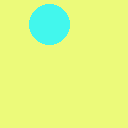

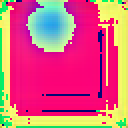

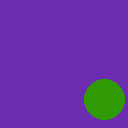

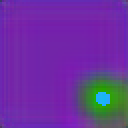

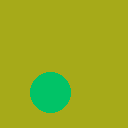

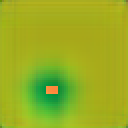

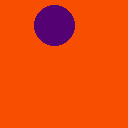

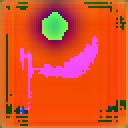

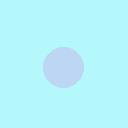

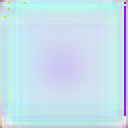

In [136]:
autoencoder.eval()
for image in dataset_test:
    result = autoencoder(image)
    tensor_to_image(image.data).show()
    tensor_to_image(result.data).show()
